In [1]:
from pathlib import Path
import os
import json
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from gym_recording_modified.playback import get_recordings
from utils.data_extractors import *
from utils.visualizations import *
import seaborn as sns
from scipy.stats import sem
from scipy.signal import convolve2d

In [2]:
root = Path('results_ablation')
filters = {
    'buffer_size' : [10000],
    'env': ['envs:random_maze-v0', 'CartPole-v1']}

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, ep_lens = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)


df1 = pd.DataFrame(params)
df2 = pd.DataFrame(ep_lens)

df = pd.concat([df1, df2], axis=1)
df.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Episode Lengths']
df = df.drop(['Seed'],axis=1)
df['Algorithm'] = df['Model'] + ', ' + df['L'] 
df = df.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df = df.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df = df.replace('FFN, 1', 'DQN-MB, 1')
df = df.replace('FFN, 2', 'DQN-MB, 2')
df = df.replace('FFN, 4', 'DQN-MB, 4')
df = df.replace('FFN, 8', 'DQN-MB, 8')

df = df.replace('RNN, 1', 'DRQN-ZHS, 1')
df = df.replace('RNN, 2', 'DRQN-ZHS, 2')
df = df.replace('RNN, 4', 'DRQN-ZHS, 4')
df = df.replace('RNN, 8', 'DRQN-ZHS, 8')

df['params'] = df['Learning Freq.'] + ', ' + df['Target Update Freq.'] + ', ' + df['Step Size'] + ', ' + df['Buffer Size']

df = df.drop(['Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'], axis=1)


3600it [01:25, 42.10it/s]


In [3]:
root = Path('results_ablation_2')
None

cutoffs = {
    'envs:random_maze-v0' : 1000,
    'CartPole-v1' : -1
}

params, ep_lens = extract_episode_lengths(root, ['model_arch', 'env', 'seed', 'learning_freq', 'target_update_freq', 'seq_len', 'learning_rate', 'buffer_size'], filters, cutoffs)

df1 = pd.DataFrame(params)
df2 = pd.DataFrame(ep_lens)

df_best = pd.concat([df1, df2], axis=1)
df_best.columns = ['Model', 'Env', 'Seed', 'Learning Freq.', 'Target Update Freq.', 'L', 'Step Size', 'Buffer Size', 
'Episode Lengths']
df_best = df_best.drop(['Seed'],axis=1)
df_best['Algorithm'] = df_best['Model'] + ', ' + df_best['L'] 
df_best = df_best.drop(['Model', 'L' ], axis=1)

columns = ['Algorithm', 'Env', 'Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'] #parameters

# rename environments
df_best = df_best.replace('envs:random_maze-v0', 'Maze')

# rename Algorithms
df_best = df_best.replace('FFN, 1', 'DQN')
df_best  = df_best.replace('RNN, 1', 'DRQN, 1')
df_best = df_best.replace('RNN, 2', 'DRQN, 2')
df_best  = df_best.replace('RNN, 4', 'DRQN, 4')
df_best  = df_best.replace('RNN, 8', 'DRQN, 8')

df_best['params'] = df_best['Learning Freq.'] + ', ' + df_best['Target Update Freq.'] + ', ' + df_best['Step Size'] + ', ' + df_best['Buffer Size']

df_best = df_best.drop(['Learning Freq.', 'Target Update Freq.', 'Step Size', 'Buffer Size'], axis=1)

1600it [00:19, 83.62it/s]


In [4]:
df_combined = pd.concat([df, df_best])

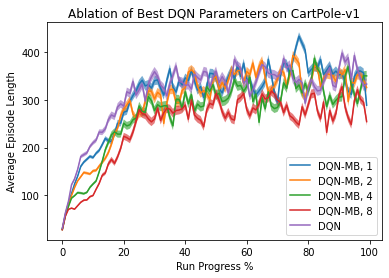

In [5]:

# BEST DQN on Cartpole
envs = ['CartPole-v1']

for env in envs:
    algs = []
    plt.figure()
    ax = plt.gca()
    df_env =  df_combined.loc[df_combined['Env'] == env]
    for param in df_env.params.unique():
        if param != '1, 100, 0.0005, 10000':
            break

        df_param = df_env.loc[df_env['params'] == param]
        for alg in df_param.Algorithm.unique():            
            if 'DQN' not in alg:
                continue

            df_alg = df_param.loc[df_param['Algorithm'] == alg]

            if alg =='DQN':
                df_alg = df_alg[:50]
            algs.append(alg)

            data = df_alg['Episode Lengths'].values
            n_bins = 100
            bin_size = 200000/n_bins
            bins = [[] for i in range(n_bins)]

            for run in data:
                sum_ = 0
                for i, ep_len in enumerate(run):
                    ind = int(sum_ // bin_size)  # which bin to place data (based on start time)
                    bins[ind].append(ep_len)
                    sum_ += ep_len 


            mean = np.array([ np.sum(i)/len(i) for i in bins])
            sigma = np.array([np.std(i,axis=0)/np.sqrt(len(i)) for i in bins])
            t = np.linspace(0, n_bins-1, n_bins)
            plt.plot(mean)
            ax.fill_between(t, mean+sigma, mean-sigma, alpha=0.6)

        plt.xlabel('Run Progress %')
        plt.ylabel('Average Episode Length')
        plt.title('Ablation of Best DQN Parameters on ' + env )
        plt.legend(algs, frameon=False)
        plt.savefig("figures/DQN_ablation.pdf", bbox_inches='tight')

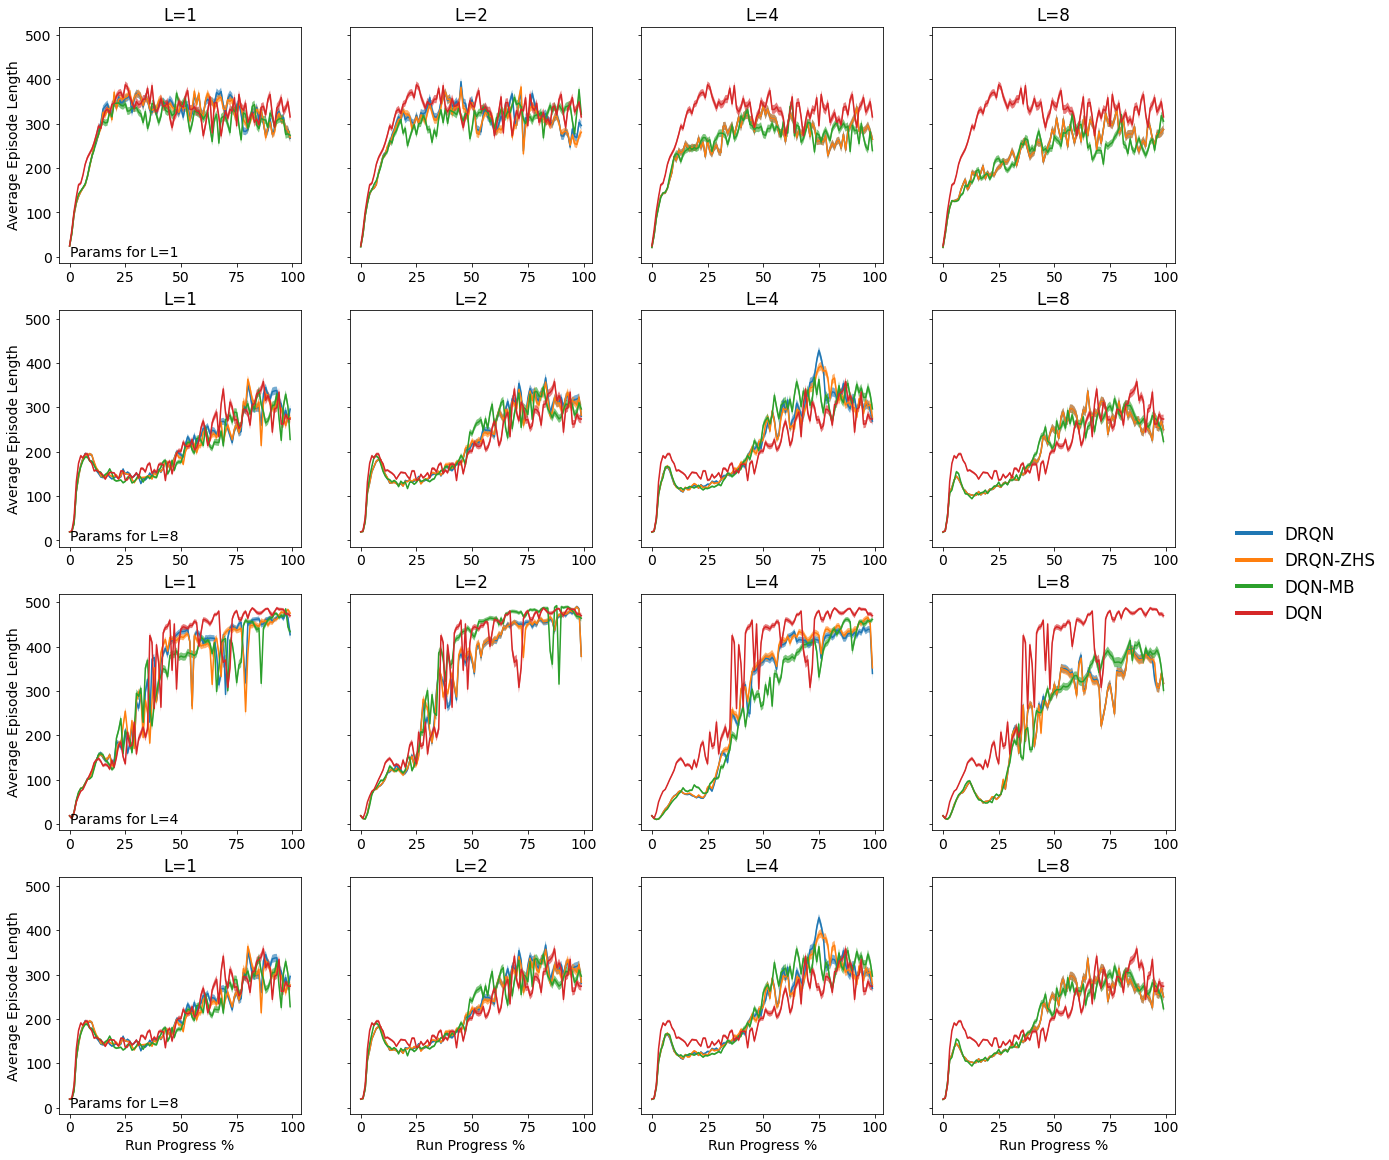

In [22]:
# BEST DQN on Cartpole
BEST_PARAMS = [
    '10, 100, 0.005, 10000',
    '10, 1000, 0.005, 10000',
    '1, 100, 5e-05, 10000',
    '10, 1000, 0.005, 10000'
]


best_dict = {
    '10, 100, 0.005, 10000' : 1,
    '10, 1000, 0.005, 10000': 2,
    '1, 100, 5e-05, 10000': 4,
    '10, 1000, 0.005, 10000':8
}

font = {'size'   : 14}

matplotlib.rc('font', **font)
envs = ['CartPole-v1']

for env in envs:   
    df_env =  df_combined.loc[df_combined['Env'] == env]
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20,20), sharey=True)    
    ax_row_idx = 0

    for param in BEST_PARAMS:
        ax_col_idx = 0
        for seq_len in ['1','2','4','8']:
            ax = axs[ax_row_idx, ax_col_idx]
            algs = []
            df_param = df_env.loc[df_env['params'] == param]

    
            for alg in ['DRQN, ' + seq_len, 'DRQN-ZHS, ' + seq_len, 'DQN-MB, ' + seq_len, 'DQN']:         
                df_alg = df_param.loc[df_param['Algorithm'] == alg]
                
                if 'ZHS' not in alg:
                    df_alg = df_alg[:50]
                
                algs.append(alg)
                
                data = df_alg['Episode Lengths'].values
                n_bins = 100
                bin_size = 200000/n_bins
                bins = [[] for i in range(n_bins)]

                for run in data:
                    sum_ = 0
                    for i, ep_len in enumerate(run):
                        ind = int(sum_ // bin_size)  # which bin to place data (based on start time)
                        bins[ind].append(ep_len)
                        sum_ += ep_len 

                mean = np.array([ np.sum(i)/len(i) for i in bins])
                sigma = np.array([np.std(i,axis=0)/np.sqrt(len(i)) for i in bins])
                t = np.linspace(0, n_bins-1, n_bins)
                ax.plot(mean)
                ax.fill_between(t, mean+sigma, mean-sigma, alpha=0.6)
        
            if ax_col_idx == 0:
                ax.set_ylabel('Average Episode Length')
                ax.annotate("Params for L=%d" % best_dict[param],xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-pad,0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center)

            if ax_row_idx == 3:
                ax.set_xlabel('Run Progress %')
            ax_col_idx += 1

            ax.set_title('L=' + seq_len  )

        ax_row_idx += 1

    leg = fig.legend(['DRQN', 'DRQN-ZHS', 'DQN-MB',  'DQN'], loc='center right', fontsize='large', frameon=False, bbox_to_anchor=(1.05, 0.5))
    for line in leg.get_lines():
        line.set_linewidth(4.0)
    plt.savefig('figures/zero_hidden_cartpole.pdf', bbox_inches='tight')
    

In [8]:

new = list()
for i in df_combined['Episode Lengths'].values:
    new.append(len(i))

df_combined['Episode Lengths'] = new
df_combined = df_combined.loc[df_combined['params']== '1, 100, 0.0005, 10000']

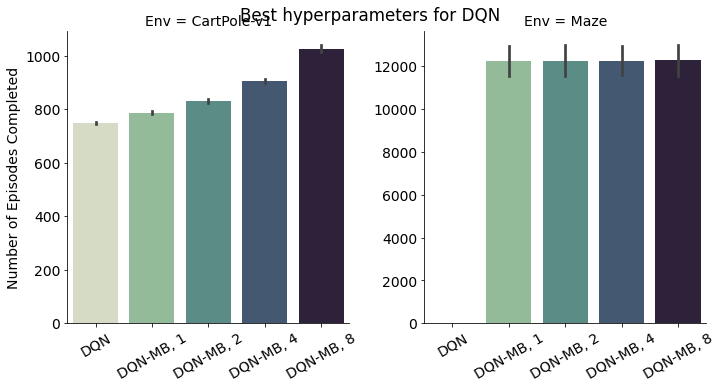

In [9]:
g = sns.catplot(x='Algorithm', y='Episode Lengths', col='Env', data=df_combined[df_combined['Algorithm'].str.contains('DQN')], kind='bar', ci=68, sharey=False, palette= sns.cubehelix_palette(5, start=.5, rot=-.75), order= ['DQN', 'DQN-MB, 1', 'DQN-MB, 2', 'DQN-MB, 4', 'DQN-MB, 8' ])
g.set_axis_labels("", "Number of Episodes Completed")
g.set_xticklabels(rotation=30)
g.fig.suptitle("Best hyperparameters for DQN")
plt.savefig('figures/total_best_DQN_ablation.pdf', bbox_inches='tight')



In [13]:
len(sns.color_palette().as_hex())

10